In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import pymc as pm

In [2]:
def load_data():
    df = pd.read_excel("./data/d18O NGRIP 21.04.24.xlsx", 
                       sheet_name="Raw Data", header=None, 
                       engine="openpyxl")
    
    df_data = df.iloc[10:6124,2:4]
    df_data.columns = ["Age", "d18o"]
    
    # set first year to 0 and choose years less than "n_years"
    df_data["Age"] -= min(df_data["Age"])
    if n_years is not None:
        df_data = df_data[df_data["Age"] <= n_years]
    
    # center data
    df_data["d18o"] -= np.mean(df_data["d18o"]) 
    
    t = df_data["Age"].values.astype("float")
    y = df_data["d18o"].values.astype("float")

    return t, y

def extract_harmonics(t, y, threshold_ratio=3, n_samples=1000, n_tune=1000, 
                      n_chains=2, target_accept=0.95, save_params=False):
    
    residuals = y.copy()

    harmonics = []
    periods_found = []
    params = {
        "P": [], "dP": [], "A": [], "dA": [], "Phi": [], "dPhi": []
    }

    for i in range(max_harmonics):
        # feedback
        print_feedback(i)

        # find dominant period
        P_guess = dominant_period(t, residuals, threshold_ratio)

        # fit harmonic
        fit_params, trace = fit_harmonic(t, residuals, P_guess, n_samples=n_samples, 
                                         n_tune=n_tune, n_chains=n_chains, 
                                         target_accept=target_accept)
        P, dP, A, dA, Phi, dPhi = fit_params
        harmonic = build_model(t, A, P, Phi)
        residuals -= harmonic

        harmonics.append(harmonic)
        params["P"].append(P)
        params["dP"].append(dP)
        params["A"].append(A)
        params["dA"].append(dA)
        params["Phi"].append(Phi)
        params["dPhi"].append(dPhi)

    final_model = np.sum(harmonics, axis=0)
    harmonics_params = pd.DataFrame(params).sort_values("P", ascending=False)

    if save_params:
        filename = f"{int(t[0])}-{int(t[-1])}y_{n_harmonics}ha_{n_samples}s_{n_tune}t_{n_chains}c"
        harmonics_params.to_excel(f"./data/{filename}.xlsx", index=False)
        print(f"Saved file in ./data/{filename}.xlsx")

    return final_model, harmonics_params, residuals

def print_feedback(current_iteration):
    print(60 * "-")
    text = f" Iteration number {current_iteration+1} of {max_harmonics} "
    left_text = " " * ((60 - len(text))//2)
    right_text = " " * (60 - len(left_text))
    print(f"{left_text}{text}{right_text}")
    print(60 * "-")

def dominant_period(t, y, threshold_ratio=10):
    # uniform t and y for fourier transform
    dt  = np.median(np.diff(t))
    t_u = np.arange(t[0], t[-1] + dt, dt)
    y_u = np.interp(t_u, t, y)

    # get frequencies and find peaks
    frequencies = np.fft.rfftfreq(len(y_u), dt)
    ck = np.fft.rfft(y_u)
    power = np.abs(ck)**2

    # calculate noise from median of lower 80% of power values
    #sorted_power = np.sort(power)
    #ix_lower_values = int(0.8 * len(sorted_power))
    #noise_floor = np.median(sorted_power[:ix_lower_values])

    # find peaks above noise floor
    max_peak = np.max(power)
    peaks, _ = find_peaks(power, height=max_peak / threshold_ratio)

    # check similar periods and find the best
    ...
    dominant_peak_idx = peaks[np.argmax(power[peaks])]

    # convert to period
    dominant_period = 1 / frequencies[dominant_peak_idx]

    # plot power with selected peaks
    '''plt.plot(power, c="steelblue")
    plt.plot(peaks, power[peaks], ".r")
    plt.title(f"Found {len(peaks)} peaks.")
    plt.xlabel("Ck")
    plt.ylabel("Power")
    plt.show()'''

    return dominant_period

def fit_harmonic(t, y, period_guess, n_samples=1000, n_tune=1000, 
                 n_chains=2, target_accept=0.95):

    y_std = y.std()

    with pm.Model() as harmonic:
        # priors
        A = pm.HalfNormal("A", sigma=y_std)
        P = pm.Normal("P", mu=period_guess, sigma=0.1*period_guess)
        phi = pm.Uniform("phi", lower=0, upper=2*np.pi)
        sig = pm.HalfNormal("sigma", sigma=y_std)

        mu = A * pm.math.cos(2*np.pi * t / P + phi)
        pm.Normal("y_obs", mu=mu, sigma=sig, observed=y)

        trace = pm.sample(n_samples, tune=n_tune, chains=n_chains,
                          cores=min(4, n_chains),
                          target_accept=target_accept,
                          return_inferencedata=True
                         )
    
    P_hat   = trace.posterior["P"].mean().item()
    A_hat   = trace.posterior["A"].mean().item()
    Phi_hat = trace.posterior["phi"].mean().item()
    dP_hat   = trace.posterior["P"].std().item()
    dA_hat   = trace.posterior["A"].std().item()
    dPhi_hat = trace.posterior["phi"].std().item()

    return (P_hat, dP_hat, A_hat, dA_hat, Phi_hat, dPhi_hat), trace

def build_model(t, A, P, phi):
    return A * np.cos(2 * np.pi * t / P + phi)

'''def show_results(t, y, model, residuals=None):
    plt.figure(figsize=(8, 6))
    plt.plot(t, y,  lw=0.2, c="k", label="Original Data")
    plt.plot(t, model, "-", label="Bayesian Fit")
    if residuals is not None:
        plt.plot(t, residuals, lw=0.2, label="Residuals")
    
    plt.legend()
    plt.title("Bayesian Harmonic Fit")
    plt.xlabel("Time")
    plt.ylabel("Signal")
    plt.grid(True)
    plt.show()'''

def show_results(t, y, model, residuals):
    fig, axes = plt.subplots(2, 1, figsize=(12, 6))
    
    # plot proposed total fit
    axes[0].plot(t, y, 'k-', alpha=0.5, linewidth=0.5, label='Original Data')
    axes[0].plot(t, model, 'r-', linewidth=2, 
                label='Bayesian Fit')
    axes[0].set_title('Bayesian Hrmonic Fit')
    axes[0].set_ylabel('Signal')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # plot proposed residuals
    axes[1].plot(t, residuals, 'b-', linewidth=0.8, alpha=0.7)
    res_std = np.std(residuals)
    axes[1].axhline(res_std, color='red', linestyle='--', alpha=0.7, 
                   label=f'±1σ = ±{res_std:.4f}')
    axes[1].axhline(-res_std, color='red', linestyle='--', alpha=0.7)
    axes[1].set_title('Residuals')
    axes[1].set_xlabel('Time')
    axes[1].set_ylabel('Residual')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [7]:
n_years = 30000
max_harmonics = 20

In [8]:
t, y = load_data()
model, params, residuals = extract_harmonics(t, y, max_harmonics, n_samples=1000, 
                  n_tune=1000, n_chains=4, save_params=False)

------------------------------------------------------------
                  Iteration number 1 of 20                                            
------------------------------------------------------------


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, P, phi, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


------------------------------------------------------------
                  Iteration number 2 of 20                                            
------------------------------------------------------------


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, P, phi, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


------------------------------------------------------------
                  Iteration number 3 of 20                                            
------------------------------------------------------------


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, P, phi, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


------------------------------------------------------------
                  Iteration number 4 of 20                                            
------------------------------------------------------------


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, P, phi, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


------------------------------------------------------------
                  Iteration number 5 of 20                                            
------------------------------------------------------------


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, P, phi, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


------------------------------------------------------------
                  Iteration number 6 of 20                                            
------------------------------------------------------------


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, P, phi, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


------------------------------------------------------------
                  Iteration number 7 of 20                                            
------------------------------------------------------------


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, P, phi, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


------------------------------------------------------------
                  Iteration number 8 of 20                                            
------------------------------------------------------------


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, P, phi, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


------------------------------------------------------------
                  Iteration number 9 of 20                                            
------------------------------------------------------------


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, P, phi, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


------------------------------------------------------------
                 Iteration number 10 of 20                                             
------------------------------------------------------------


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, P, phi, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


------------------------------------------------------------
                 Iteration number 11 of 20                                             
------------------------------------------------------------


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, P, phi, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


------------------------------------------------------------
                 Iteration number 12 of 20                                             
------------------------------------------------------------


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, P, phi, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


------------------------------------------------------------
                 Iteration number 13 of 20                                             
------------------------------------------------------------


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, P, phi, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


------------------------------------------------------------
                 Iteration number 14 of 20                                             
------------------------------------------------------------


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, P, phi, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


------------------------------------------------------------
                 Iteration number 15 of 20                                             
------------------------------------------------------------


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, P, phi, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


------------------------------------------------------------
                 Iteration number 16 of 20                                             
------------------------------------------------------------


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, P, phi, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


------------------------------------------------------------
                 Iteration number 17 of 20                                             
------------------------------------------------------------


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, P, phi, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


------------------------------------------------------------
                 Iteration number 18 of 20                                             
------------------------------------------------------------


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, P, phi, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


------------------------------------------------------------
                 Iteration number 19 of 20                                             
------------------------------------------------------------


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, P, phi, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


------------------------------------------------------------
                 Iteration number 20 of 20                                             
------------------------------------------------------------


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, P, phi, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


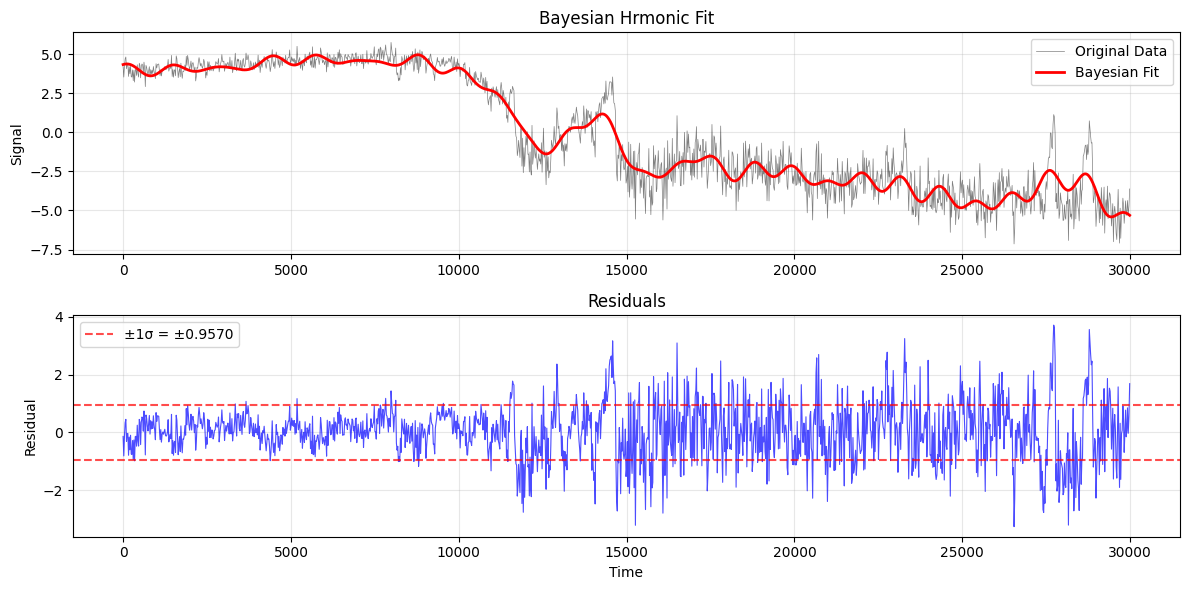

In [9]:
show_results(t, y, model, residuals)

In [10]:
params

,P,dP,A,dA,Phi,dPhi
0,42501.803401,623.064439,4.417579,0.044696,5.714738,0.032977
1,16181.719168,262.479627,0.834869,0.046231,3.625701,0.110849
9,9725.736244,268.325470,4.037419,0.088477,2.787755,2.786721
10,9586.154297,8.408890,8.115033,0.037194,5.747152,0.009962
5,9430.513825,193.325039,0.363162,0.037707,3.185212,2.983519
6,9416.927547,94.926071,0.727002,0.038328,3.173745,3.054635
8,9415.067359,25.679021,2.910066,0.037735,1.600809,2.696931
7,9409.965595,50.005345,1.454120,0.037317,3.164575,3.092436
17,6216.431301,114.113259,0.285775,0.037921,3.640432,0.227482
2,4461.014561,33.151488,0.574506,0.041958,5.178731,0.183234


=== JAYNES BAYESIAN HARMONIC ANALYSIS ===
Close frequency threshold: 0.001333
Data length: 1500, Time span: 29985.2

--- Iteration 1 ---
Found 125 significant peaks above SNR threshold 3.0
Dominant period: 4288.57, frequency: 0.000233
Found 19 close frequencies, fitting simultaneously


/tmp/ipykernel_16933/2161169045.py:138: RuntimeWarning: divide by zero encountered in divide
  periods = np.where(frequencies > 0, 1.0/frequencies, np.inf)


Variance explained: 2.96%
Current model SNR: 0.03

--- Iteration 2 ---
Found 127 significant peaks above SNR threshold 3.0
Dominant period: 4288.57, frequency: 0.000233
Found 17 close frequencies, fitting simultaneously
Harmonic explains only 0.18% variance. Stopping.

=== FINAL RESULTS ===
Found 1 harmonics
Total variance explained: 3.0%


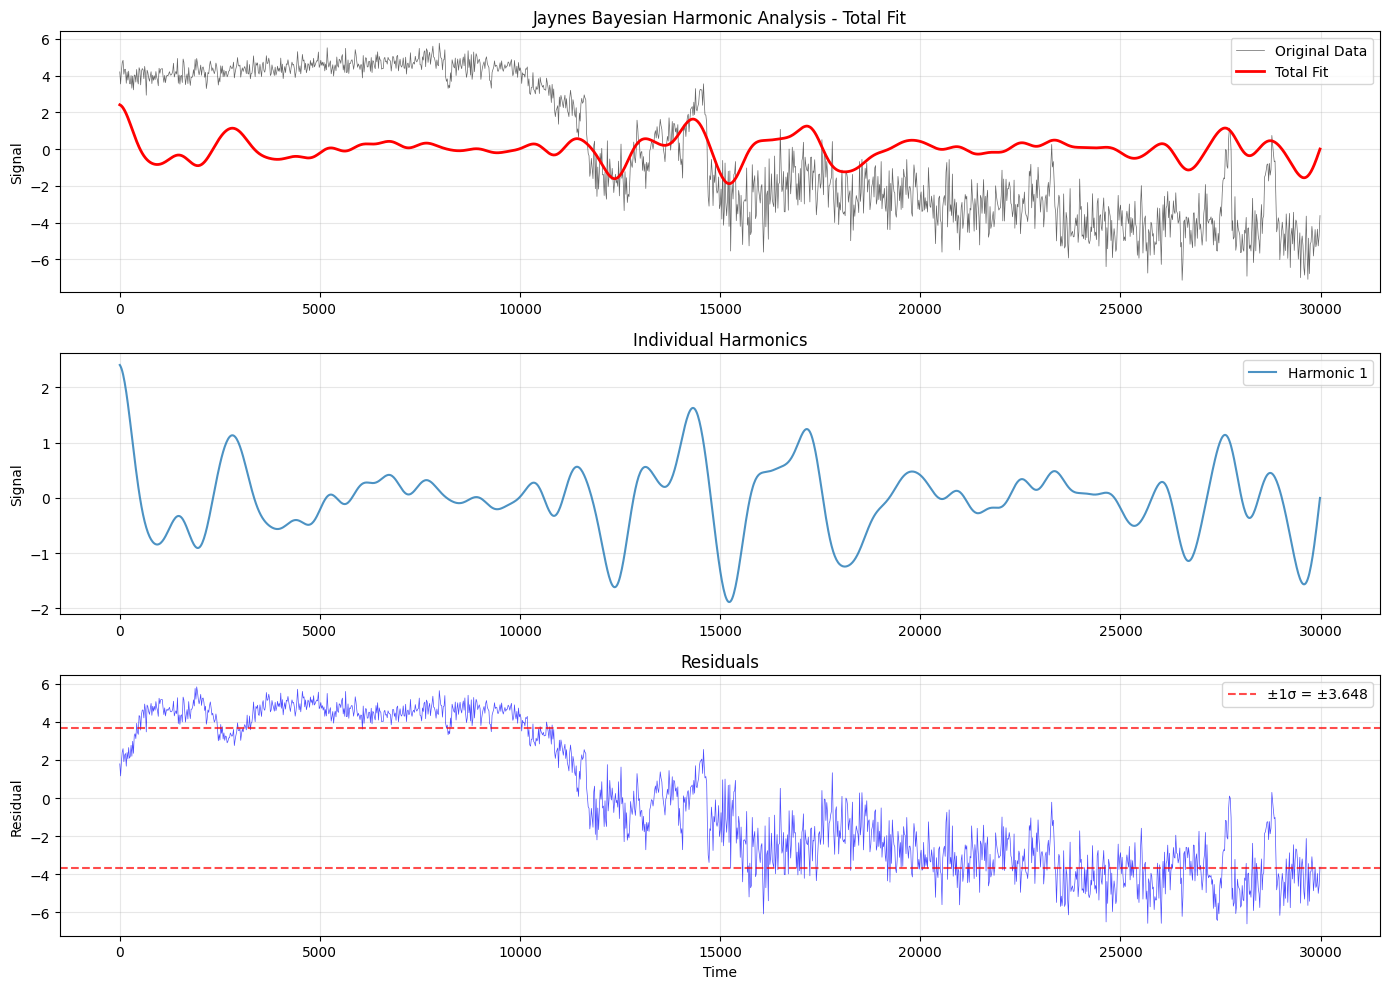


=== HARMONIC PARAMETERS ===
   Harmonic     Period  Frequency  Amplitude   Phase  Variance_Explained
0       1.1  4288.9781     0.0002     0.0000  0.0000              0.1555
1       1.2  7514.3627     0.0001     0.1810  0.0000              0.1555
2       1.3  3399.5724     0.0003     0.4836  0.0000              0.1555
3       1.4  2814.1188     0.0004     0.5462  0.1773              0.1555
4       1.5  2370.8274     0.0004     0.2456  0.0990              0.1555
5       1.6  2016.8464     0.0005     0.0003  0.0000              0.1555
6       1.7  1850.0969     0.0005     0.0000  0.3085              0.1555
7       1.8  1607.7969     0.0006     0.2346  0.0000              0.1555
8       1.9  1445.6815     0.0007     0.3528  0.0402              0.1555
9      1.10  1346.3018     0.0007     0.0000  0.0000              0.1555
10     1.11  1317.4886     0.0008     0.2784  0.3388              0.1555
11     1.12  1173.6159     0.0009     0.0000  6.2832              0.1555
12     1.13  1072.0730

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.optimize import minimize
import pymc as pm


def load_data(n_years=None):
    df = pd.read_excel("./data/d18O NGRIP 21.04.24.xlsx", 
                       sheet_name="Raw Data", header=None, 
                       engine="openpyxl")
    
    df_data = df.iloc[10:6124,2:4]
    df_data.columns = ["Age", "d18o"]
    
    # set first year to 0 and choose years less than "n_years"
    df_data["Age"] -= min(df_data["Age"])
    if n_years is not None:
        df_data = df_data[df_data["Age"] <= n_years]
    
    # center data
    df_data["d18o"] -= np.mean(df_data["d18o"]) 
    
    t = df_data["Age"].values.astype("float")
    y = df_data["d18o"].values.astype("float")

    return t, y

def jaynes_harmonic_analysis(t, y, snr_threshold=3.0, close_freq_threshold=None, 
                           max_harmonics=10, variance_threshold=1.0):
    """
    Implement Jaynes' method for harmonic analysis
    
    Parameters:
    - close_freq_threshold: If None, automatically set to 2/N where N is data length
    - variance_threshold: Stop when harmonic explains less than this % of variance
    """
    
    if close_freq_threshold is None:
        close_freq_threshold = 2.0 / len(t)  # As suggested by Jaynes
    
    residuals = y.copy()
    original_variance = np.var(y)
    
    harmonics = []
    all_params = []
    
    print("=== JAYNES BAYESIAN HARMONIC ANALYSIS ===")
    print(f"Close frequency threshold: {close_freq_threshold:.6f}")
    print(f"Data length: {len(t)}, Time span: {t[-1]-t[0]:.1f}")
    
    for iteration in range(max_harmonics):
        print(f"\n--- Iteration {iteration + 1} ---")
        
        # Step 1: Compute periodogram of residuals
        periods, power, noise_floor = compute_periodogram(t, residuals)
        
        # Step 2: Find significant peaks
        significant_peaks = find_significant_peaks(power, noise_floor, snr_threshold)
        
        if len(significant_peaks) == 0:
            print("No more significant peaks found. Stopping.")
            break
        
        # Step 3: Get the strongest peak
        strongest_peak_idx = significant_peaks[np.argmax(power[significant_peaks])]
        dominant_period = periods[strongest_peak_idx]
        dominant_freq = 1.0 / dominant_period
        
        print(f"Dominant period: {dominant_period:.2f}, frequency: {dominant_freq:.6f}")
        
        # Step 4: Check for close frequencies
        close_peaks = find_close_frequencies(significant_peaks, periods, dominant_freq, 
                                           close_freq_threshold, power)
        
        if len(close_peaks) > 1:
            print(f"Found {len(close_peaks)} close frequencies, fitting simultaneously")
            # Fit multiple close frequencies together
            params, harmonic = fit_multiple_close_frequencies(t, residuals, 
                                                            [periods[i] for i in close_peaks])
        else:
            print("Single frequency, fitting individually")
            # Fit single frequency
            params, harmonic = fit_single_frequency_mle(t, residuals, dominant_period)
        
        # Step 5: Check if this harmonic explains enough variance
        variance_before = np.var(residuals)
        residuals_new = residuals - harmonic
        variance_after = np.var(residuals_new)
        variance_explained = (variance_before - variance_after) / original_variance * 100
        
        if variance_explained < variance_threshold:
            print(f"Harmonic explains only {variance_explained:.2f}% variance. Stopping.")
            break
        
        # Step 6: Accept this harmonic
        residuals = residuals_new
        harmonics.append(harmonic)
        all_params.append(params)
        
        print(f"Variance explained: {variance_explained:.2f}%")
        
        # Check if residuals are now just noise
        final_snr = np.var(np.sum(harmonics, axis=0)) / np.var(residuals) if np.var(residuals) > 0 else np.inf
        print(f"Current model SNR: {final_snr:.2f}")
    
    # Summary
    if len(harmonics) > 0:
        final_model = np.sum(harmonics, axis=0)
        total_variance = sum([p.get('variance_explained', 0) for p in all_params])
        
        print(f"\n=== FINAL RESULTS ===")
        print(f"Found {len(harmonics)} harmonics")
        print(f"Total variance explained: {total_variance:.1f}%")
        
        # Create summary dataframe
        summary_df = create_summary_dataframe(all_params)
        
        return final_model, summary_df, residuals, harmonics
    else:
        print("No harmonics found!")
        return np.zeros_like(y), pd.DataFrame(), y, []

def compute_periodogram(t, y):
    """Compute periodogram using DFT - the 'sufficient statistic' mentioned by Jaynes"""
    # Uniform sampling for FFT
    dt = np.median(np.diff(t))
    t_uniform = np.arange(t[0], t[-1] + dt, dt)
    y_uniform = np.interp(t_uniform, t, y)
    
    # Compute DFT
    frequencies = np.fft.rfftfreq(len(y_uniform), dt)
    fft_coeffs = np.fft.rfft(y_uniform)
    power = np.abs(fft_coeffs)**2
    
    # Convert to periods (excluding zero frequency)
    periods = np.where(frequencies > 0, 1.0/frequencies, np.inf)
    
    # Estimate noise floor (as in Jaynes approach)
    sorted_power = np.sort(power[1:])  # Exclude DC component
    noise_floor = np.median(sorted_power[:int(0.8 * len(sorted_power))])
    
    return periods[1:], power[1:], noise_floor  # Exclude DC component

def find_significant_peaks(power, noise_floor, snr_threshold):
    """Find peaks significantly above noise floor"""
    min_height = noise_floor * snr_threshold
    peaks, _ = find_peaks(power, height=min_height)
    
    print(f"Found {len(peaks)} significant peaks above SNR threshold {snr_threshold}")
    return peaks

def find_close_frequencies(peak_indices, periods, dominant_freq, threshold, power):
    """Identify frequencies that are 'close' according to Jaynes criterion"""
    dominant_period = 1.0 / dominant_freq
    close_peaks = [peak_indices[np.argmax(power[peak_indices])]]  # Start with dominant peak
    
    for peak_idx in peak_indices:
        freq = 1.0 / periods[peak_idx]
        if abs(freq - dominant_freq) <= threshold and peak_idx not in close_peaks:
            close_peaks.append(peak_idx)
    
    return close_peaks

def fit_single_frequency_mle(t, y, period_guess):
    """Fit single frequency using Maximum Likelihood (simpler than full Bayesian)"""
    
    def neg_log_likelihood(params):
        A, period, phi, sigma = params
        if sigma <= 0 or A < 0:
            return np.inf
        
        model = A * np.cos(2 * np.pi * t / period + phi)
        residuals = y - model
        
        # Negative log likelihood (assuming Gaussian noise)
        nll = len(y) * np.log(sigma) + 0.5 * np.sum(residuals**2) / (sigma**2)
        return nll
    
    # Initial guess
    A_init = np.std(y) * 2
    sigma_init = np.std(y) * 0.5
    phi_init = 0.0
    
    # Bounds
    bounds = [(0, 5*np.std(y)),  # A > 0
              (period_guess*0.8, period_guess*1.2),  # period
              (0, 2*np.pi),  # phi
              (np.std(y)*0.1, np.std(y)*2)]  # sigma
    
    # Optimize
    result = minimize(neg_log_likelihood, 
                     [A_init, period_guess, phi_init, sigma_init],
                     bounds=bounds, method='L-BFGS-B')
    
    if result.success:
        A, period, phi, sigma = result.x
        harmonic = A * np.cos(2 * np.pi * t / period + phi)
        
        params = {
            'A': A, 'period': period, 'phi': phi, 'sigma': sigma,
            'frequency': 1.0/period,
            'variance_explained': (np.var(y) - np.var(y - harmonic)) / np.var(y) * 100,
            'n_frequencies': 1
        }
        
        return params, harmonic
    else:
        print("MLE optimization failed!")
        return {}, np.zeros_like(y)

def fit_multiple_close_frequencies(t, y, periods_guess):
    """Fit multiple close frequencies simultaneously"""
    n_freq = len(periods_guess)
    
    def neg_log_likelihood(params):
        # params: [A1, period1, phi1, A2, period2, phi2, ..., sigma]
        if len(params) != 3*n_freq + 1:
            return np.inf
        
        sigma = params[-1]
        if sigma <= 0:
            return np.inf
        
        model = np.zeros_like(t)
        for i in range(n_freq):
            A = params[3*i]
            period = params[3*i + 1]
            phi = params[3*i + 2]
            
            if A < 0:
                return np.inf
            
            model += A * np.cos(2 * np.pi * t / period + phi)
        
        residuals = y - model
        nll = len(y) * np.log(sigma) + 0.5 * np.sum(residuals**2) / (sigma**2)
        return nll
    
    # Initial guess and bounds
    init_params = []
    bounds = []
    
    for period_guess in periods_guess:
        init_params.extend([np.std(y), period_guess, 0.0])
        bounds.extend([(0, 5*np.std(y)), 
                      (period_guess*0.9, period_guess*1.1), 
                      (0, 2*np.pi)])
    
    init_params.append(np.std(y) * 0.5)  # sigma
    bounds.append((np.std(y)*0.1, np.std(y)*2))
    
    # Optimize
    result = minimize(neg_log_likelihood, init_params, bounds=bounds, method='L-BFGS-B')
    
    if result.success:
        params_opt = result.x
        sigma = params_opt[-1]
        
        # Build combined model
        model = np.zeros_like(t)
        individual_params = []
        
        for i in range(n_freq):
            A = params_opt[3*i]
            period = params_opt[3*i + 1]
            phi = params_opt[3*i + 2]
            
            component = A * np.cos(2 * np.pi * t / period + phi)
            model += component
            
            individual_params.append({
                'A': A, 'period': period, 'phi': phi, 'frequency': 1.0/period
            })
        
        combined_params = {
            'individual_frequencies': individual_params,
            'sigma': sigma,
            'variance_explained': (np.var(y) - np.var(y - model)) / np.var(y) * 100,
            'n_frequencies': n_freq
        }
        
        return combined_params, model
    else:
        print("Multi-frequency MLE optimization failed!")
        return {}, np.zeros_like(y)

def create_summary_dataframe(all_params):
    """Create summary dataframe from all fitted parameters"""
    rows = []
    
    for i, params in enumerate(all_params):
        if params.get('n_frequencies', 1) == 1:
            rows.append({
                'Harmonic': i+1,
                'Period': params['period'],
                'Frequency': params['frequency'],
                'Amplitude': params['A'],
                'Phase': params['phi'],
                'Variance_Explained': params['variance_explained']
            })
        else:
            # Multiple close frequencies
            for j, freq_params in enumerate(params['individual_frequencies']):
                rows.append({
                    'Harmonic': f"{i+1}.{j+1}",
                    'Period': freq_params['period'],
                    'Frequency': freq_params['frequency'],
                    'Amplitude': freq_params['A'],
                    'Phase': freq_params['phi'],
                    'Variance_Explained': params['variance_explained'] / len(params['individual_frequencies'])
                })
    
    return pd.DataFrame(rows)

def show_jaynes_results(t, y, model, residuals, harmonics, params_df):
    """Enhanced visualization for Jaynes method results"""
    
    fig, axes = plt.subplots(3, 1, figsize=(14, 10))
    
    # Plot 1: Original data and total fit
    axes[0].plot(t, y, 'k-', alpha=0.6, linewidth=0.5, label='Original Data')
    axes[0].plot(t, model, 'r-', linewidth=2, label='Total Fit')
    axes[0].set_title('Jaynes Bayesian Harmonic Analysis - Total Fit')
    axes[0].set_ylabel('Signal')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Individual harmonics
    colors = plt.cm.tab10(np.linspace(0, 1, len(harmonics)))
    for i, (harmonic, color) in enumerate(zip(harmonics, colors)):
        axes[1].plot(t, harmonic, color=color, linewidth=1.5, 
                    label=f'Harmonic {i+1}', alpha=0.8)
    
    axes[1].set_title('Individual Harmonics')
    axes[1].set_ylabel('Signal')
    if len(harmonics) <= 6:  # Only show legend if not too crowded
        axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Plot 3: Residuals
    axes[2].plot(t, residuals, 'b-', linewidth=0.5, alpha=0.7)
    res_std = np.std(residuals)
    axes[2].axhline(res_std, color='red', linestyle='--', alpha=0.7, label=f'±1σ = ±{res_std:.3f}')
    axes[2].axhline(-res_std, color='red', linestyle='--', alpha=0.7)
    axes[2].set_title('Residuals')
    axes[2].set_xlabel('Time')
    axes[2].set_ylabel('Residual')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary table
    if len(params_df) > 0:
        print("\n=== HARMONIC PARAMETERS ===")
        print(params_df.round(4))
    
    # Print diagnostics
    print(f"\nDiagnostics:")
    print(f"Original data std: {np.std(y):.4f}")
    print(f"Residual data std: {np.std(residuals):.4f}")
    print(f"Noise reduction: {(1 - np.std(residuals)/np.std(y))*100:.1f}%")


# Example usage
if __name__ == "__main__":
    t, y = load_data(n_years=30000)
    
    # Run Jaynes method
    model, params_df, residuals, harmonics = jaynes_harmonic_analysis(
        t, y,
        snr_threshold=3.0,          # Standard threshold
        close_freq_threshold=None,   # Auto-calculate based on data length
        max_harmonics=10,           # Maximum to search for
        variance_threshold=1.0      # Stop if harmonic explains <1% variance
    )
    
    # Show results
    show_jaynes_results(t, y, model, residuals, harmonics, params_df)

=== INTERACTIVE HARMONIC EXTRACTION ===
At each step, you can choose:
  'c' or 'continue' - Accept current harmonic and continue
  's' or 'stop' - Stop here and return current results
  'b' or 'back' - Go back to previous step
  'q' or 'quit' - Quit without saving

------------------------------------------------------------
 STEP 1 - Looking for harmonic #1 
------------------------------------------------------------


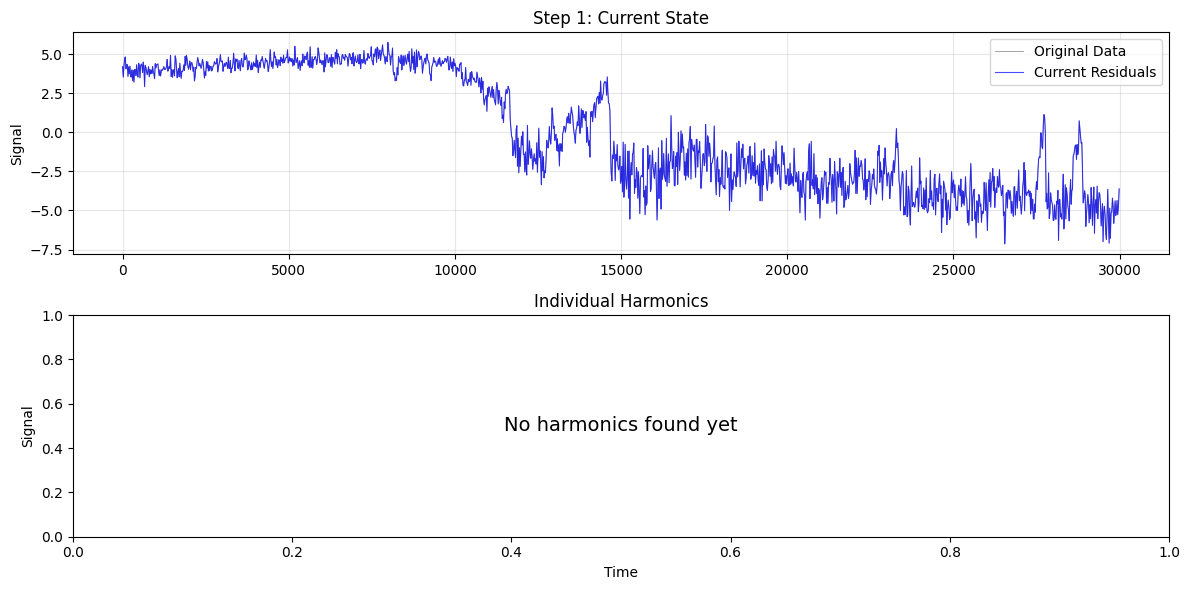

/tmp/ipykernel_16933/1990450953.py:208: RuntimeWarning: divide by zero encountered in divide
  periods = np.where(frequencies > 0, 1.0/frequencies, np.inf)


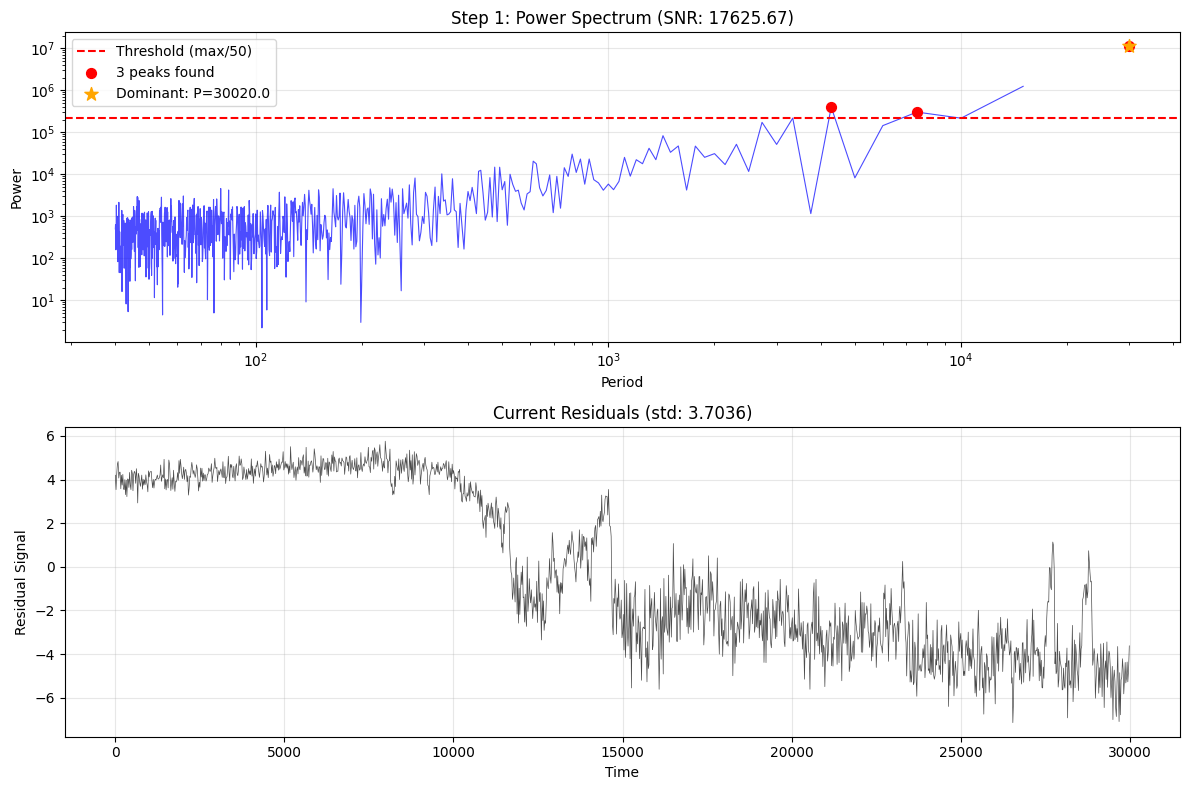

SNR: 17625.67 (threshold: 50)
Has harmonics: True
Peaks found: 3
Found potential harmonic with period: 30020.00, SNR: 17625.67
Fitting harmonic with Bayesian analysis...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, P, phi, sigma]


KeyboardInterrupt: 

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import pymc as pm

def load_data(n_years=None):
    df = pd.read_excel("./data/d18O NGRIP 21.04.24.xlsx", 
                       sheet_name="Raw Data", header=None, 
                       engine="openpyxl")
    
    df_data = df.iloc[10:6124,2:4]
    df_data.columns = ["Age", "d18o"]
    
    # set first year to 0 and choose years less than "n_years"
    df_data["Age"] -= min(df_data["Age"])
    if n_years is not None:
        df_data = df_data[df_data["Age"] <= n_years]
    
    # center data
    df_data["d18o"] -= np.mean(df_data["d18o"]) 
    
    t = df_data["Age"].values.astype("float")
    y = df_data["d18o"].values.astype("float")

    return t, y

def interactive_extract_harmonics(t, y, snr_threshold=50, n_samples=1000, n_tune=1000, 
                                n_chains=2, target_accept=0.95, save_params=False):
    """
    Interactive harmonic extraction with user control at each step
    """
    
    # Store states for going back
    states = {
        'residuals': [y.copy()],  # Start with original data
        'harmonics': [[]],        # Start with no harmonics
        'params': [{"P": [], "dP": [], "A": [], "dA": [], "Phi": [], "dPhi": []}],
        'models': [np.zeros_like(y)]  # Start with zero model
    }
    
    current_step = 0
    
    print("=== INTERACTIVE HARMONIC EXTRACTION ===")
    print("At each step, you can choose:")
    print("  'c' or 'continue' - Accept current harmonic and continue")
    print("  's' or 'stop' - Stop here and return current results") 
    print("  'b' or 'back' - Go back to previous step")
    print("  'q' or 'quit' - Quit without saving")
    print("=" * 50)
    
    while True:
        current_step += 1
        
        # Get current state
        residuals = states['residuals'][-1].copy()
        harmonics = states['harmonics'][-1].copy()
        params = states['params'][-1].copy()
        current_model = states['models'][-1].copy()
        
        print(f"\n{60 * '-'}")
        print(f" STEP {current_step} - Looking for harmonic #{len(harmonics) + 1} ")
        print(f"{60 * '-'}")
        
        # Show current state before finding next harmonic
        show_current_state(t, y, current_model, residuals, harmonics, current_step)
        
        # Find dominant period in current residuals
        result = dominant_period_with_plot(t, residuals, snr_threshold, current_step)
        if result is None:
            print("No more significant peaks found!")
            user_choice = input("No peaks found. Press Enter to finish: ")
            break
            
        P_guess, snr = result
        print(f"Found potential harmonic with period: {P_guess:.2f}, SNR: {snr:.2f}")
        
        # Fit the harmonic
        print("Fitting harmonic with Bayesian analysis...")
        fit_params, trace = fit_harmonic(t, residuals, P_guess, n_samples=n_samples, 
                                       n_tune=n_tune, n_chains=n_chains, 
                                       target_accept=target_accept)
        
        P, dP, A, dA, Phi, dPhi = fit_params
        new_harmonic = build_model(t, A, P, Phi)
        
        # Calculate variance explained
        variance_before = np.var(residuals)
        residuals_after = residuals - new_harmonic
        variance_after = np.var(residuals_after)
        variance_explained = (variance_before - variance_after) / np.var(y) * 100
        
        print(f"Fitted parameters:")
        print(f"  Period: {P:.2f} ± {dP:.2f}")
        print(f"  Amplitude: {A:.4f} ± {dA:.4f}")
        print(f"  Phase: {Phi:.4f} ± {dPhi:.4f}")
        print(f"  Variance explained: {variance_explained:.2f}%")
        
        # Show what the result would look like
        new_harmonics = harmonics + [new_harmonic]
        new_model = current_model + new_harmonic
        show_proposed_result(t, y, new_model, residuals_after, new_harmonics, current_step)
        
        # Get user decision
        while True:
            print(f"\nOptions:")
            print(f"  'c' - Accept this harmonic and continue")
            print(f"  's' - Stop here and use current results")
            if current_step > 1:
                print(f"  'b' - Go back to previous step")
            print(f"  'q' - Quit without saving")
            
            choice = input("Your choice: ").lower().strip()
            
            if choice in ['c', 'continue']:
                # Accept current harmonic and save state
                new_params = params.copy()
                new_params["P"].append(P)
                new_params["dP"].append(dP)
                new_params["A"].append(A)
                new_params["dA"].append(dA)
                new_params["Phi"].append(Phi)
                new_params["dPhi"].append(dPhi)
                
                states['residuals'].append(residuals_after)
                states['harmonics'].append(new_harmonics)
                states['params'].append(new_params)
                states['models'].append(new_model)
                
                print(f"✓ Accepted harmonic #{len(new_harmonics)}")
                break
                
            elif choice in ['s', 'stop']:
                print(f"✓ Stopping with {len(harmonics)} harmonics")
                current_step -= 1  # Don't count this step
                break
                
            elif choice in ['b', 'back'] and current_step > 1:
                # Go back one step
                states['residuals'].pop()
                states['harmonics'].pop() 
                states['params'].pop()
                states['models'].pop()
                current_step -= 2  # Will be incremented at start of loop
                print("↶ Going back one step")
                break
                
            elif choice in ['q', 'quit']:
                print("Quitting without results")
                return np.zeros_like(y), pd.DataFrame(), y
                
            else:
                print("Invalid choice. Please try again.")
        
        if choice in ['s', 'stop', 'q', 'quit']:
            break
    
    # Return final results
    final_harmonics = states['harmonics'][-1]
    final_params = states['params'][-1]
    final_model = states['models'][-1]
    final_residuals = states['residuals'][-1]
    
    if len(final_harmonics) > 0:
        harmonics_params = pd.DataFrame(final_params).sort_values("P", ascending=False)
        
        print(f"\n=== FINAL RESULTS ===")
        print(f"Total harmonics found: {len(final_harmonics)}")
        total_variance = np.sum([(np.var(states['residuals'][i]) - np.var(states['residuals'][i+1])) / np.var(y) * 100 
                               for i in range(len(final_harmonics))])
        print(f"Total variance explained: {total_variance:.2f}%")
        
        if save_params:
            filename = f"{int(t[0])}-{int(t[-1])}y_{len(final_harmonics)}ha_interactive"
            harmonics_params.to_excel(f"./data/{filename}.xlsx", index=False)
            print(f"Saved file in ./data/{filename}.xlsx")
        
        return final_model, harmonics_params, final_residuals
    else:
        print("No harmonics accepted.")
        return np.zeros_like(y), pd.DataFrame(), y

def dominant_period_with_plot(t, y, threshold_ratio=10, step_num=1):
    """Find dominant period and show the frequency spectrum plot"""
    
    # uniform t and y values for fourier transform
    dt = np.median(np.diff(t))
    t_u = np.arange(t[0], t[-1] + dt, dt)
    y_u = np.interp(t_u, t, y)

    # get frequencies and find peaks
    frequencies = np.fft.rfftfreq(len(y_u), dt)
    ck = np.fft.rfft(y_u)
    power = np.abs(ck)**2
    max_peak = np.max(power)
    
    # Find peaks
    peaks, _ = find_peaks(power, height=max_peak/threshold_ratio)

    # calculate snr
    snr = max_peak / np.median(power)
    has_harmonics = (snr > threshold_ratio) and (len(peaks) > 0)
    
    # Create the frequency spectrum plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    
    # Plot power spectrum
    periods = np.where(frequencies > 0, 1.0/frequencies, np.inf)
    valid_idx = (periods < (t[-1] - t[0])) & (periods > 0)
    
    ax1.loglog(periods[valid_idx], power[valid_idx], 'b-', alpha=0.7, linewidth=0.8)
    ax1.axhline(max_peak/threshold_ratio, color='red', linestyle='--', 
                label=f'Threshold (max/{threshold_ratio})')
    
    if len(peaks) > 0:
        peak_periods = periods[peaks[peaks < len(periods)]]
        peak_powers = power[peaks[peaks < len(periods)]]
        ax1.scatter(peak_periods, peak_powers, color='red', s=50, zorder=5, 
                   label=f'{len(peaks)} peaks found')
        
        # Highlight dominant peak
        if len(peaks) > 0:
            dominant_peak_idx = peaks[np.argmax(power[peaks])]
            if dominant_peak_idx < len(periods):
                dominant_period = periods[dominant_peak_idx]
                ax1.scatter([dominant_period], [power[dominant_peak_idx]], 
                           color='orange', s=100, marker='*', zorder=6,
                           label=f'Dominant: P={dominant_period:.1f}')
    
    ax1.set_xlabel('Period')
    ax1.set_ylabel('Power')
    ax1.set_title(f'Step {step_num}: Power Spectrum (SNR: {snr:.2f})')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot residuals time series
    ax2.plot(t, y, 'k-', linewidth=0.5, alpha=0.7)
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Residual Signal')
    ax2.set_title(f'Current Residuals (std: {np.std(y):.4f})')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"SNR: {snr:.2f} (threshold: {threshold_ratio})")
    print(f"Has harmonics: {has_harmonics}")
    print(f"Peaks found: {len(peaks)}")
    
    if not has_harmonics:
        return None

    # find dominant period
    dominant_peak_idx = peaks[np.argmax(power[peaks])]
    dominant_period = 1 / frequencies[dominant_peak_idx]

    return dominant_period, snr

def show_current_state(t, y, model, residuals, harmonics, step_num):
    """Show current fitting state"""
    
    fig, axes = plt.subplots(2, 1, figsize=(12, 6))
    
    # Plot current fit
    axes[0].plot(t, y, 'k-', alpha=0.5, linewidth=0.5, label='Original Data')
    if len(harmonics) > 0:
        axes[0].plot(t, model, 'r-', linewidth=2, label=f'Current Fit ({len(harmonics)} harmonics)')
    axes[0].plot(t, residuals, 'b-', alpha=0.7, linewidth=0.8, label='Current Residuals')
    axes[0].set_title(f'Step {step_num}: Current State')
    axes[0].set_ylabel('Signal')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot individual harmonics if any
    if len(harmonics) > 0:
        colors = plt.cm.tab10(np.linspace(0, 1, len(harmonics)))
        for i, (harmonic, color) in enumerate(zip(harmonics, colors)):
            axes[1].plot(t, harmonic, color=color, linewidth=1.5, 
                        label=f'Harmonic {i+1}', alpha=0.8)
        axes[1].set_title('Individual Harmonics Found So Far')
        axes[1].set_xlabel('Time')
        axes[1].set_ylabel('Signal')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
    else:
        axes[1].text(0.5, 0.5, 'No harmonics found yet', 
                    transform=axes[1].transAxes, ha='center', va='center', fontsize=14)
        axes[1].set_title('Individual Harmonics')
        axes[1].set_xlabel('Time')
        axes[1].set_ylabel('Signal')
    
    plt.tight_layout()
    plt.show()

def show_proposed_result(t, y, proposed_model, proposed_residuals, proposed_harmonics, step_num):
    """Show what the result would be if we accept the current harmonic"""
    
    fig, axes = plt.subplots(3, 1, figsize=(12, 9))
    
    # Plot proposed total fit
    axes[0].plot(t, y, 'k-', alpha=0.5, linewidth=0.5, label='Original Data')
    axes[0].plot(t, proposed_model, 'r-', linewidth=2, 
                label=f'Proposed Fit ({len(proposed_harmonics)} harmonics)')
    axes[0].set_title(f'Step {step_num}: Proposed Result')
    axes[0].set_ylabel('Signal')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot individual harmonics
    colors = plt.cm.tab10(np.linspace(0, 1, len(proposed_harmonics)))
    for i, (harmonic, color) in enumerate(zip(proposed_harmonics, colors)):
        axes[1].plot(t, harmonic, color=color, linewidth=1.5, 
                    label=f'Harmonic {i+1}', alpha=0.8)
    
    # Highlight the newest harmonic
    if len(proposed_harmonics) > 0:
        newest_harmonic = proposed_harmonics[-1]
        axes[1].plot(t, newest_harmonic, 'red', linewidth=2.5, 
                    label=f'NEW Harmonic {len(proposed_harmonics)}', alpha=1.0)
    
    axes[1].set_title('All Harmonics (NEW one highlighted in red)')
    axes[1].set_ylabel('Signal')
    if len(proposed_harmonics) <= 8:  # Only show legend if not too crowded
        axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Plot proposed residuals
    axes[2].plot(t, proposed_residuals, 'b-', linewidth=0.8, alpha=0.7)
    res_std = np.std(proposed_residuals)
    axes[2].axhline(res_std, color='red', linestyle='--', alpha=0.7, 
                   label=f'±1σ = ±{res_std:.4f}')
    axes[2].axhline(-res_std, color='red', linestyle='--', alpha=0.7)
    axes[2].set_title('Proposed Residuals')
    axes[2].set_xlabel('Time')
    axes[2].set_ylabel('Residual')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def fit_harmonic(t, y, period_guess, n_samples=1000, n_tune=1000, 
                 n_chains=2, target_accept=0.95):

    y_std = y.std()

    with pm.Model() as harmonic:
        # priors
        A = pm.HalfNormal("A", sigma=2*y_std)
        P = pm.Normal("P", mu=period_guess, sigma=0.25*period_guess)
        phi = pm.Uniform("phi", lower=0, upper=2*np.pi)
        sig = pm.HalfNormal("sigma", sigma=y_std)

        mu = A * pm.math.cos(2*np.pi * t / P + phi)
        pm.Normal("y_obs", mu=mu, sigma=sig, observed=y)

        trace = pm.sample(n_samples, tune=n_tune, chains=n_chains,
                          cores=min(4, n_chains),
                          target_accept=target_accept,
                          return_inferencedata=True
                         )
        
    P_hat   = trace.posterior["P"].mean().item()
    A_hat   = trace.posterior["A"].mean().item()
    Phi_hat = trace.posterior["phi"].mean().item()
    dP_hat   = trace.posterior["P"].std().item()
    dA_hat   = trace.posterior["A"].std().item()
    dPhi_hat = trace.posterior["phi"].std().item()

    return (P_hat, dP_hat, A_hat, dA_hat, Phi_hat, dPhi_hat), trace

def build_model(t, A, P, phi):
    return A * np.cos(2 * np.pi * t / P + phi)

def show_final_results(t, y, model, residuals=None, params_df=None):
    """Show final results with enhanced visualization"""
    
    fig, axes = plt.subplots(2, 1, figsize=(12, 8))
    
    axes[0].plot(t, y, 'k-', alpha=0.6, linewidth=0.5, label='Original Data')
    axes[0].plot(t, model, 'r-', linewidth=2, label='Final Fit')
    if residuals is not None:
        axes[0].plot(t, residuals, 'b-', alpha=0.7, linewidth=0.8, label='Final Residuals')
    
    axes[0].legend()
    axes[0].set_title("Final Bayesian Harmonic Fit")
    axes[0].set_ylabel("Signal")
    axes[0].grid(True, alpha=0.3)
    
    if residuals is not None:
        axes[1].plot(t, residuals, 'b-', linewidth=0.8)
        res_std = np.std(residuals)
        axes[1].axhline(res_std, color='red', linestyle='--', alpha=0.7, 
                       label=f'±1σ = ±{res_std:.4f}')
        axes[1].axhline(-res_std, color='red', linestyle='--', alpha=0.7)
        axes[1].set_title('Final Residuals')
        axes[1].set_xlabel('Time')
        axes[1].set_ylabel('Residual')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    if params_df is not None and len(params_df) > 0:
        print("\n=== FINAL HARMONIC PARAMETERS ===")
        print(params_df.round(4))

# Example usage
if __name__ == "__main__":
    # Load your data
    t, y = load_data(n_years=30000)
    
    # Run interactive extraction
    model, params, residuals = interactive_extract_harmonics(
        t, y, 
        snr_threshold=50,  # Your original threshold
        n_samples=1000, 
        n_tune=1000, 
        n_chains=4, 
        save_params=False
    )
    
    # Show final results
    show_final_results(t, y, model, residuals, params)